In [149]:
from pathlib import Path
import pickle

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set2", 6))
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### File paths

In [176]:
# Change paths as needed
data_dir = Path('../datasets/fraud_detection')  # Original data directory

train_tran_filename = data_dir / 'train_transaction.csv'
test_tran_filename  = data_dir / 'test_transaction.csv'
train_user_filename = data_dir / 'train_identity.csv'
test_user_filename  = data_dir / 'test_identity.csv'

train_c_filename = data_dir / 'train_combined.csv'  # Train data saved to disk
test_c_filename = data_dir / 'test_combined.csv'  # Test data saved to disk

grid_search_result_filename = data_dir / 'gs_results.pkl'  # For storing trained models
label_encoding_filename = data_dir / 'label_encoding.pkl'  # For storing label encoding of categorical variables
result_filename = data_dir / 'results.csv'  # results

### Merge transaction and user data into single file and save

In [46]:
train_t = pd.read_csv(train_tran_filename)
train_u = pd.read_csv(train_user_filename)
combined_train = train_t.merge(train_u, on=['TransactionID'], how='left')
combined_train.to_csv(train_c_filename, index=False)

del combined_train, train_t, train_u

In [29]:
# test_t = pd.read_csv(test_tran_filename)
# test_u = pd.read_csv(test_user_filename)

# # Columns in test file are of type id-01, id-02... instead of id_01... like in train file :|
# corrected_test_cols = {c:c.replace('-', '_') for c in test_u.columns if 'id-' in c}
# test_u = test_u.rename(columns=corrected_test_cols)

# combined_test = test_t.merge(test_u, on=['TransactionID'], how='left')
# combined_test.to_csv(test_c_filename, index=False)

# del combined_test, test_t, test_u

### Read data

In [78]:
data_fraction = 0.1  # Reduce if memory errors

train = pd.read_csv(train_c_filename).sample(frac=data_fraction, random_state=42)
# test = pd.read_csv(test_c_filename).sample(frac=data_fraction, random_state=42)

### Turn categorical features into numeric values

In [10]:
def cat_to_numeric(dftrain):
    
    cat_features = ['card4', 'card6', 'P_emaildomain', 'R_emaildomain', 
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
                'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 
                'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 
                'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

    lc_dict = dict()  # Stores label encoding of all categorical features

    for ft in cat_features:
        lc = LabelEncoder()
        dftrain[ft] = lc.fit_transform(dftrain[ft].astype(str))
        lc_dict[ft] = lc
    return dftrain, lc

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 470624 to 121958
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [12]:
train, lc = cat_to_numeric(train)

In [80]:
# Write label encoding to disk
with open(label_encoding_filename, 'wb') as f:
    pickle.dump(lc, f)

### Reconcile every feature's presence

In [13]:
# Reconcile every feature's presence (check if you are not missing any feature in your analysis)

products = ['C', 'H', 'R', 'S', 'W']
mix_cols = ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'isFraud']
dist_cols = [x for x in train.columns if 'dist' in x]
card_cols = [x for x in train.columns if 'card' in x]
addr_cols = [x for x in train.columns if 'addr' in x]
email_cols = [x for x in train.columns if 'emaildomain' in x]
c_cols = [f'C{x}' for x in range(1, 15)]
d_cols = [f'D{x}' for x in range(1, 16)]
m_cols = [f'M{x}' for x in range(1, 10)]
v_cols = [f'V{x}' for x in range(1, 340)]
id_cols = [f'id_{x:02}' for x in range(1, 39)]
device_cols = ['DeviceType', 'DeviceInfo']
coltypes = [dist_cols, mix_cols, card_cols, addr_cols, email_cols, c_cols, d_cols, m_cols, v_cols, id_cols, device_cols]


all_cols = list()
for ctype in coltypes:
    for x in ctype:
        all_cols.append(x)
        try:
            assert x in train.columns
        except AssertionError:
            print(x)
            
assert set(all_cols) == set(train.columns)

### Define final features

In [14]:
label_col = 'isFraud'
transaction_cols = ['TransactionAmt']

features = []
features += transaction_cols
features += dist_cols
features += card_cols
features += addr_cols
features += email_cols
features += c_cols + d_cols + m_cols + v_cols
features += id_cols
features += device_cols
print(f'Total columns: {len(all_cols)}\nTotal features: {len(features)}')

Total columns: 434
Total features: 430


### Split data into training and testing

In [16]:
train.shape

(590540, 434)

In [29]:
id_cols = ['TransactionID', 'TransactionDT', 'ProductCD']

X_train, X_test, y_train, y_test = train_test_split(train[features + id_cols], train[label_col], test_size=0.33, random_state=42)

In [83]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (395661, 433)
X_test shape: (194879, 433)
y_train shape: (395661,)
y_test shape: (194879,)


# EDA

### Null percentage in features

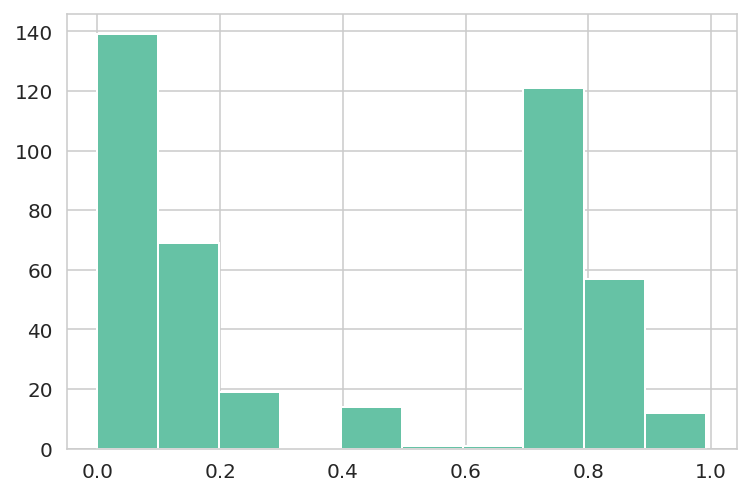

In [31]:
null_perc = (X_train.isnull().sum()/len(X_train)).sort_values(ascending=False)
null_perc.hist()

Distinct blocks of features with one block having the least amount, one block with around 50% nulls and the last block with over 80% nulls.

### Feature names

**Feature information**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr1, addr2: address
- dist1, dist2: distance
- (P_) and (R_) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

### Null value blocks

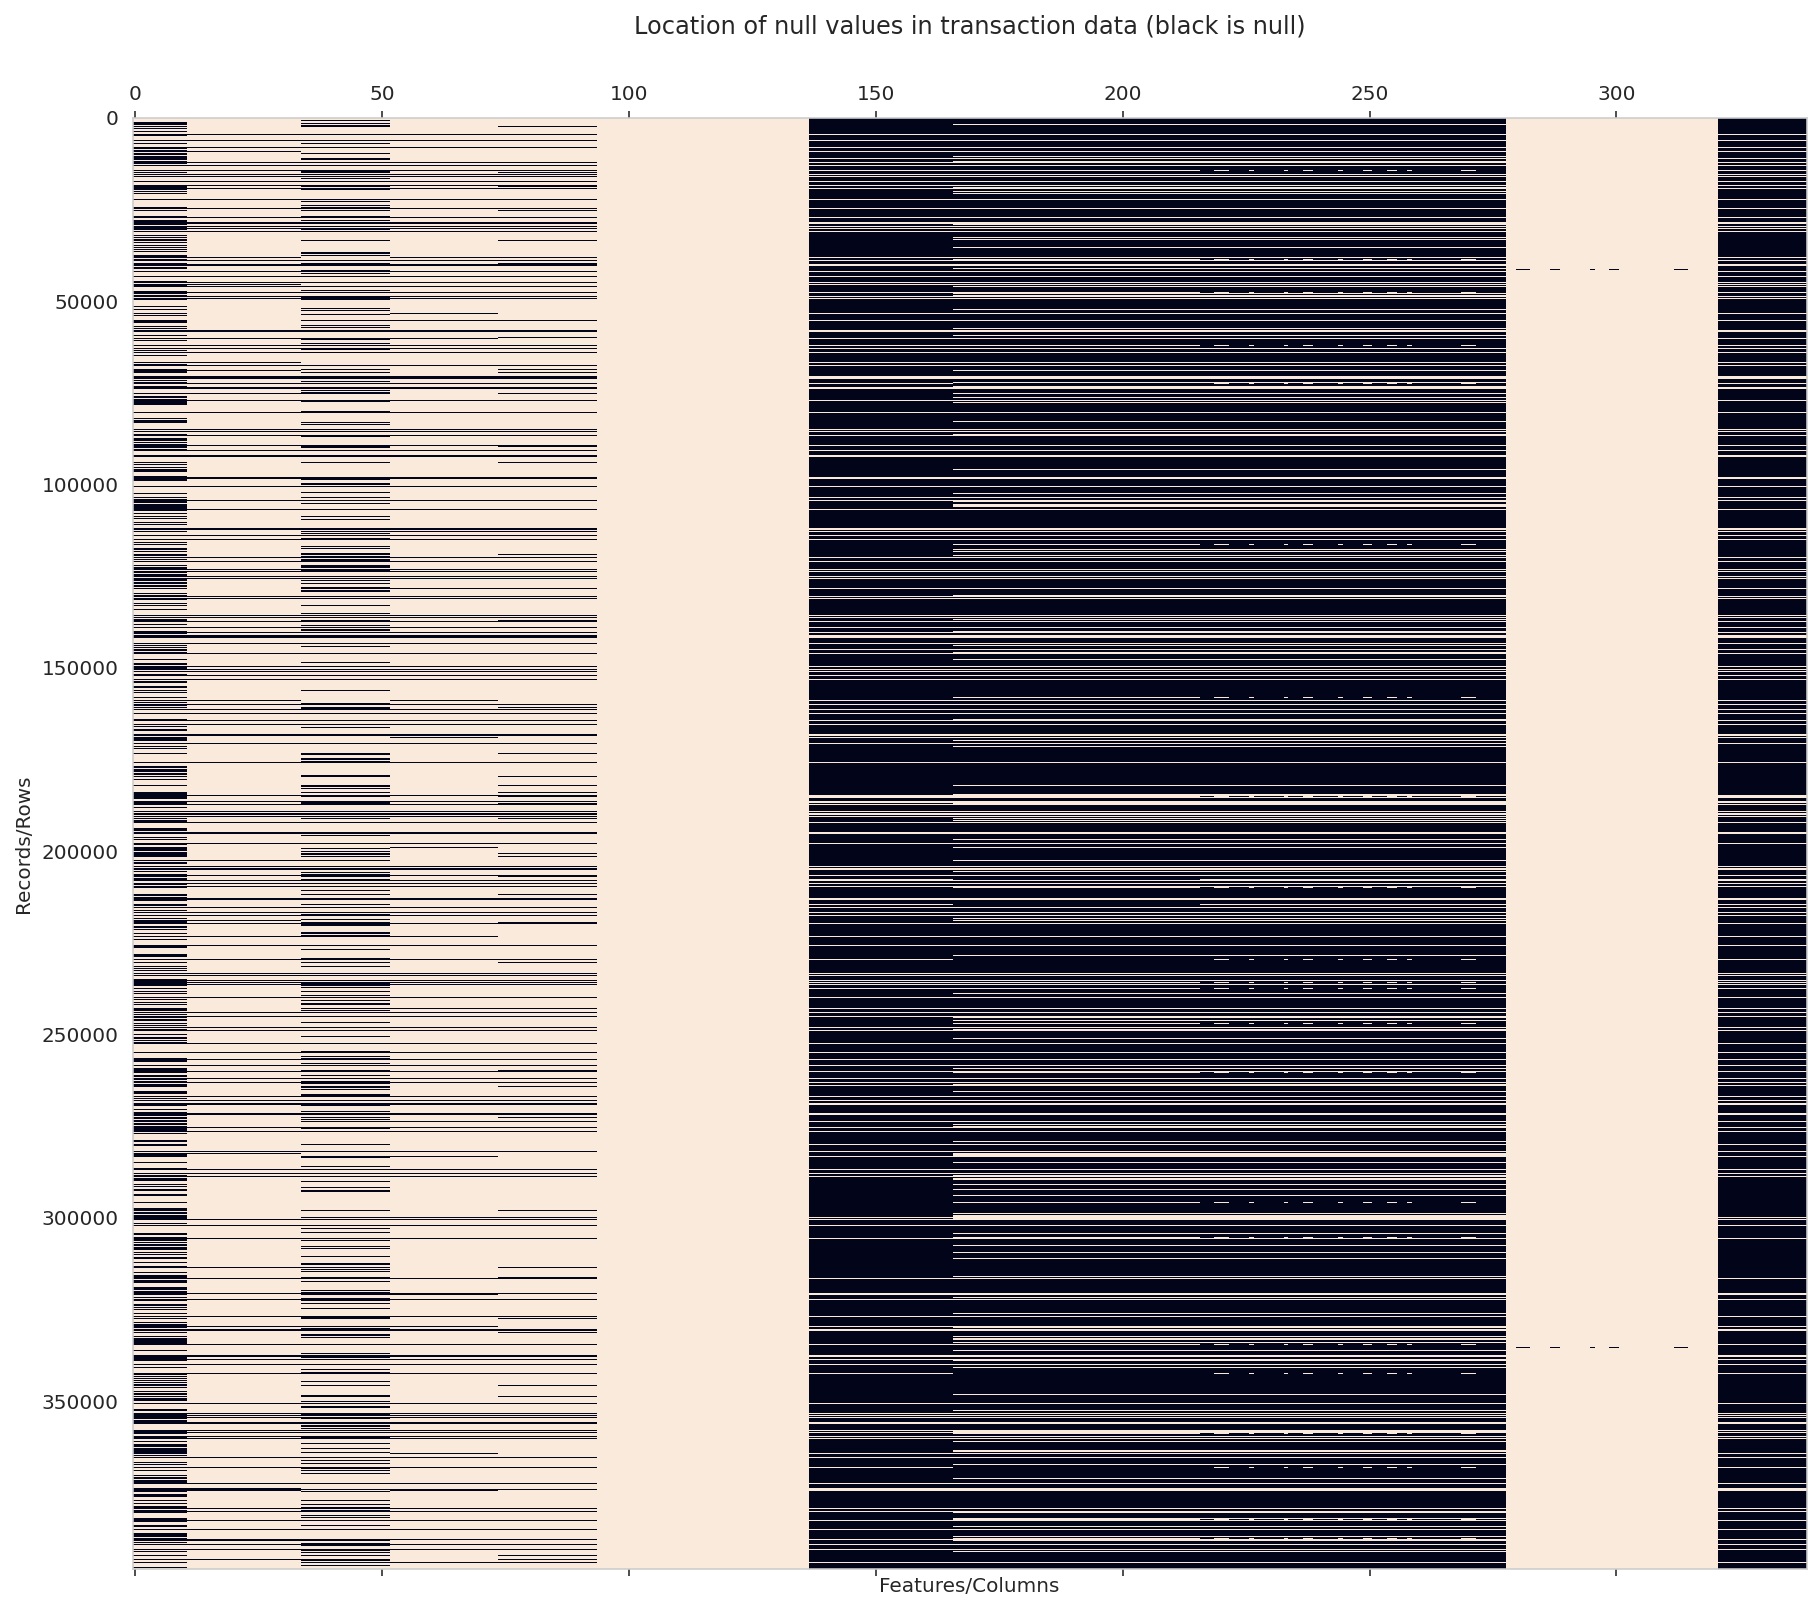

In [23]:
plt.figure(figsize=(15,13))
plt.matshow((~X_train[v_cols].isnull()).astype(int), fignum=1)
ax = plt.gca()
ax.set_aspect('auto')
ax.set_title('Location of null values in transaction data (black is null)')
ax.set_xlabel('Features/Columns')
ax.set_ylabel('Records/Rows')
plt.grid(False)
plt.show()

### Fraud percentage across products

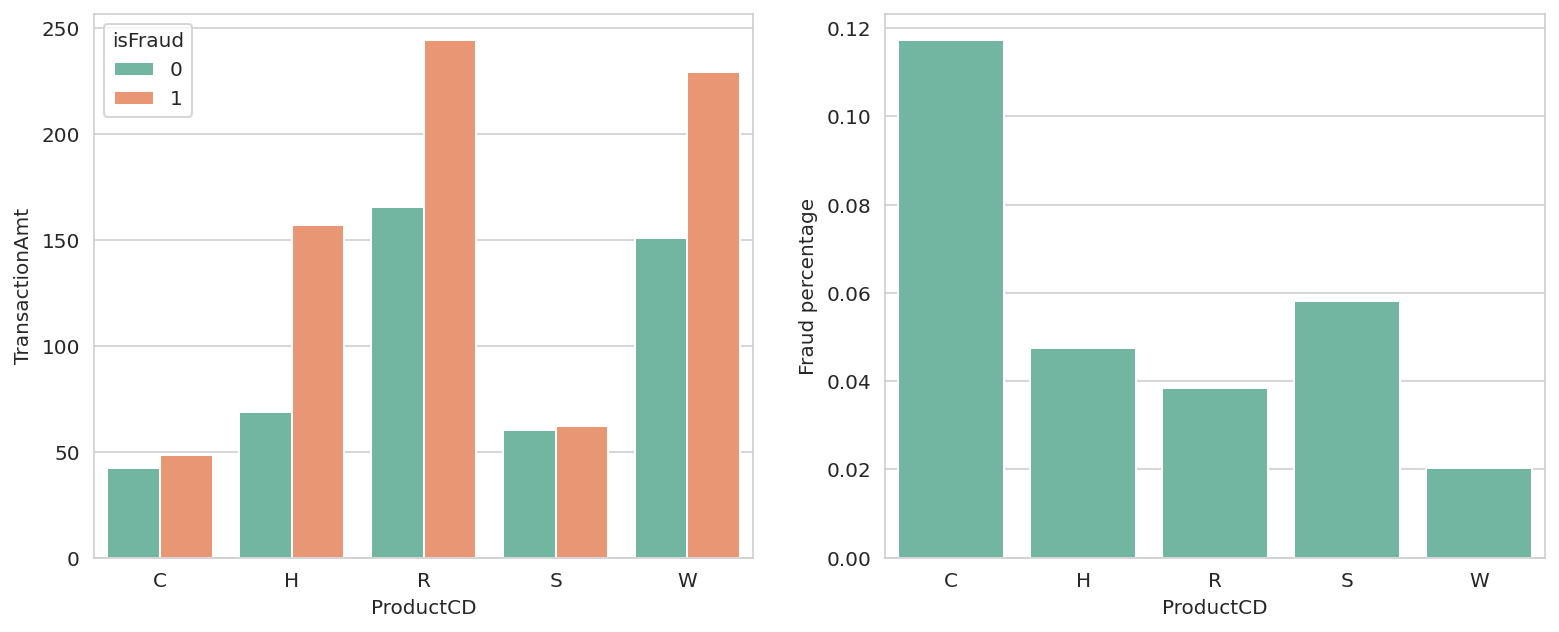

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

t = (
    X_train.join(y_train)
    .groupby(by=['ProductCD', 'isFraud'])
    .agg({
        'TransactionID': 'count', 
        'TransactionAmt': 'mean'
    })
    .reset_index()
    .assign(TransactionID = lambda x: x['TransactionID']/x.groupby(by='ProductCD')['TransactionID'].transform(sum))
    .rename(columns={'TransactionID': 'Fraud percentage'})

)

sns.barplot(data=t, x='ProductCD', y='TransactionAmt', hue='isFraud', ax=ax[0])
sns.barplot(data=t[t['isFraud'] == 1], x='ProductCD', y='Fraud percentage', ax=ax[1], color=sns.color_palette()[0])

# plt.title('Transaction amount for each product split by fraud status')

### Null percentage across product split by fraud status

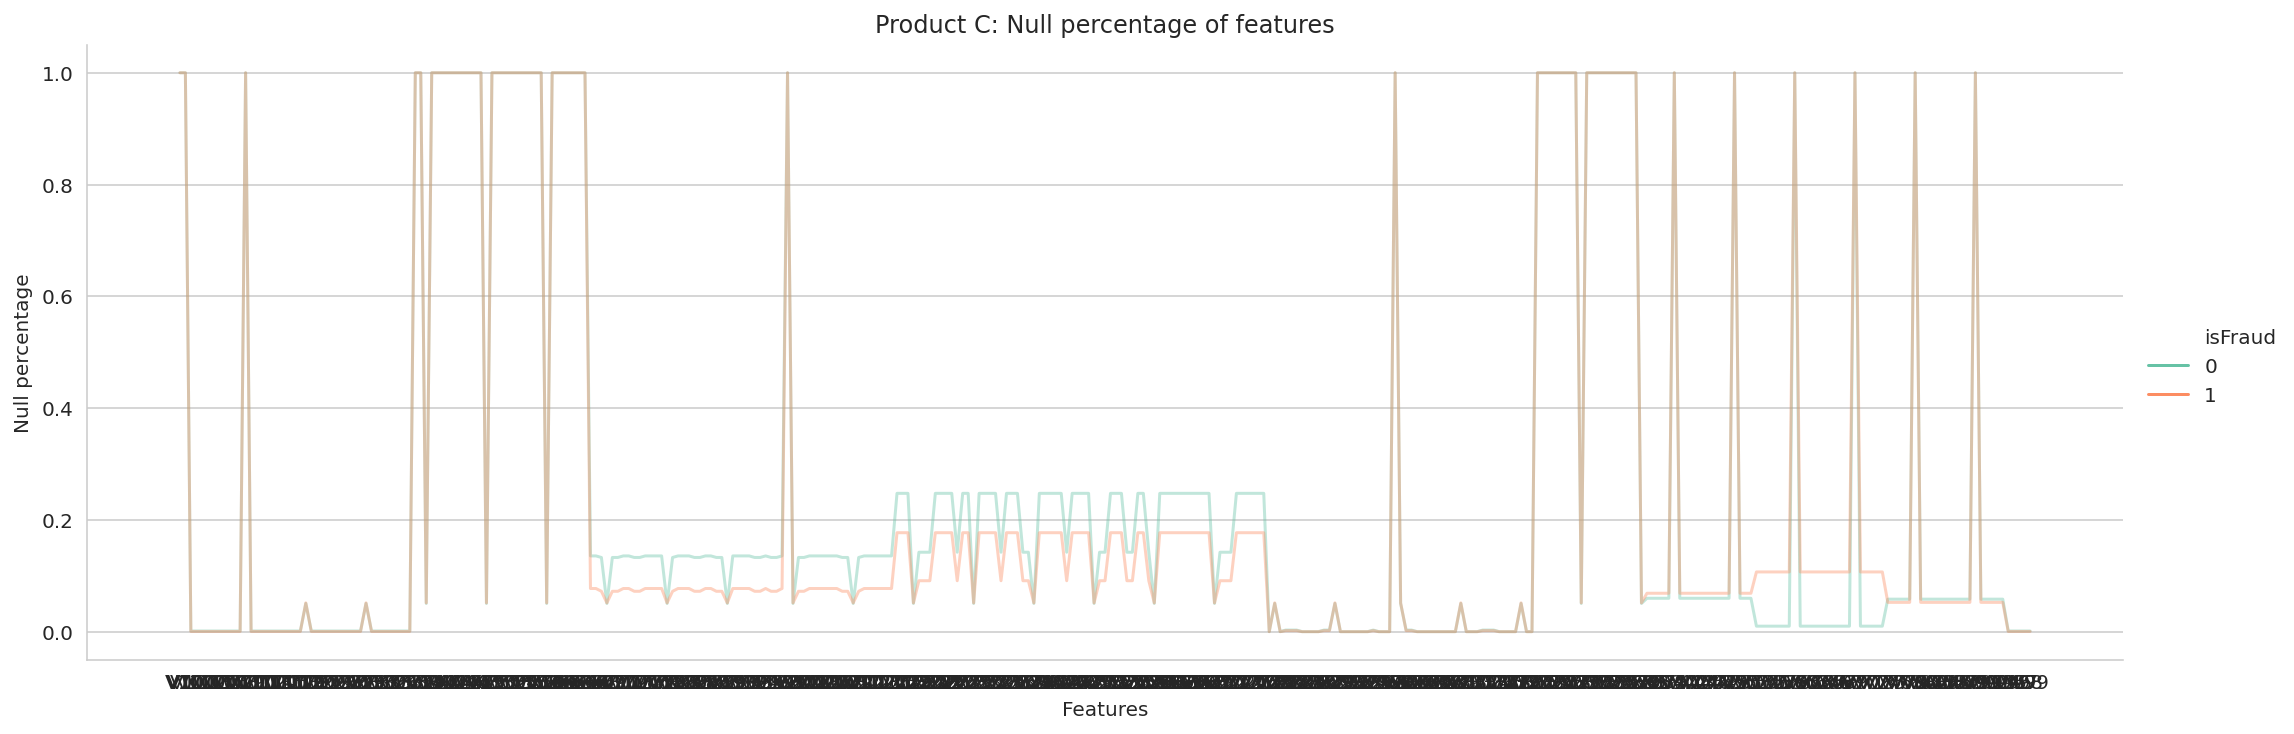

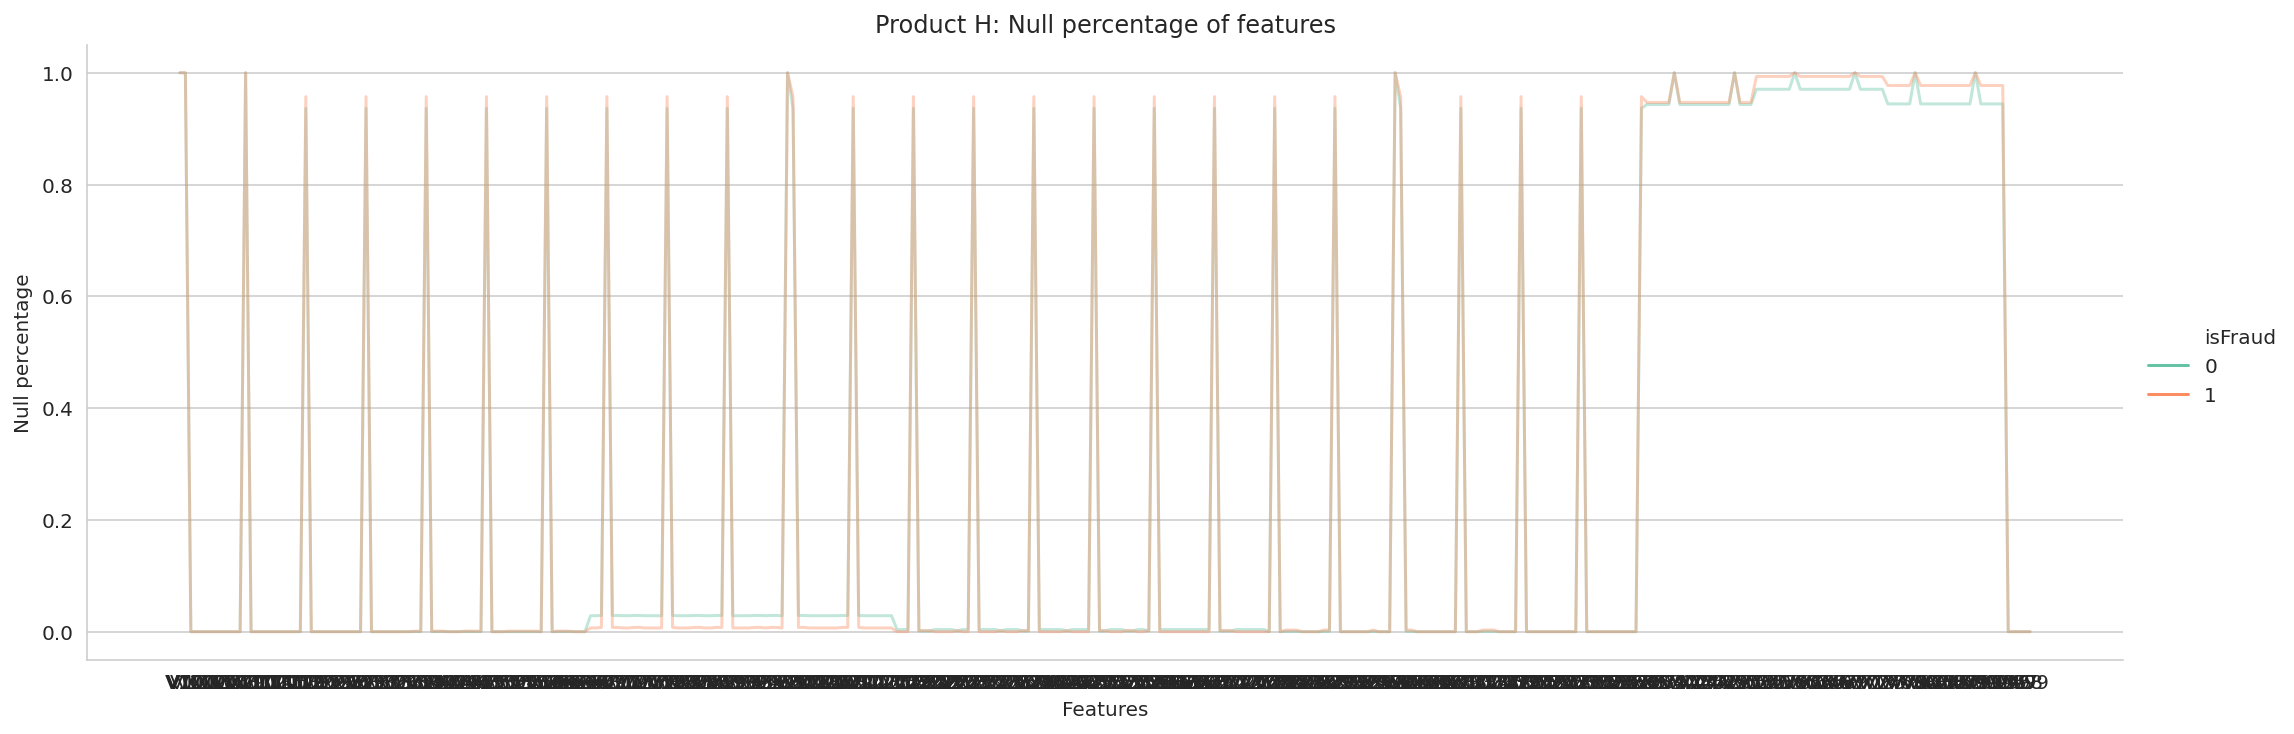

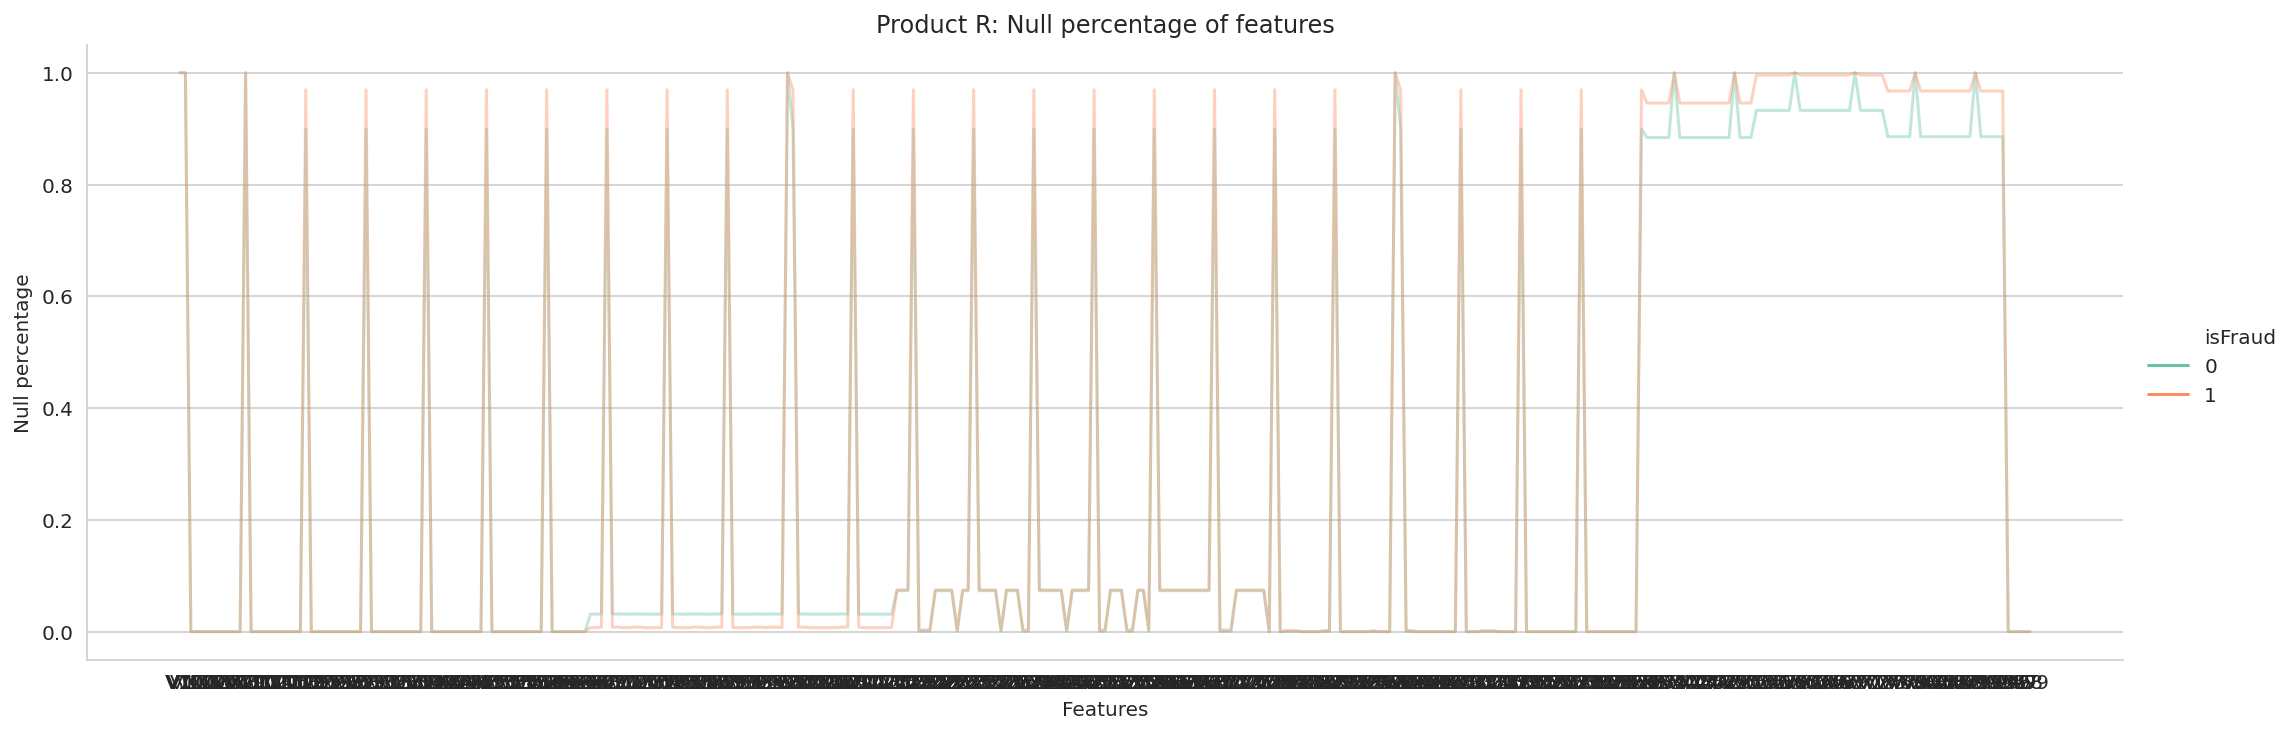

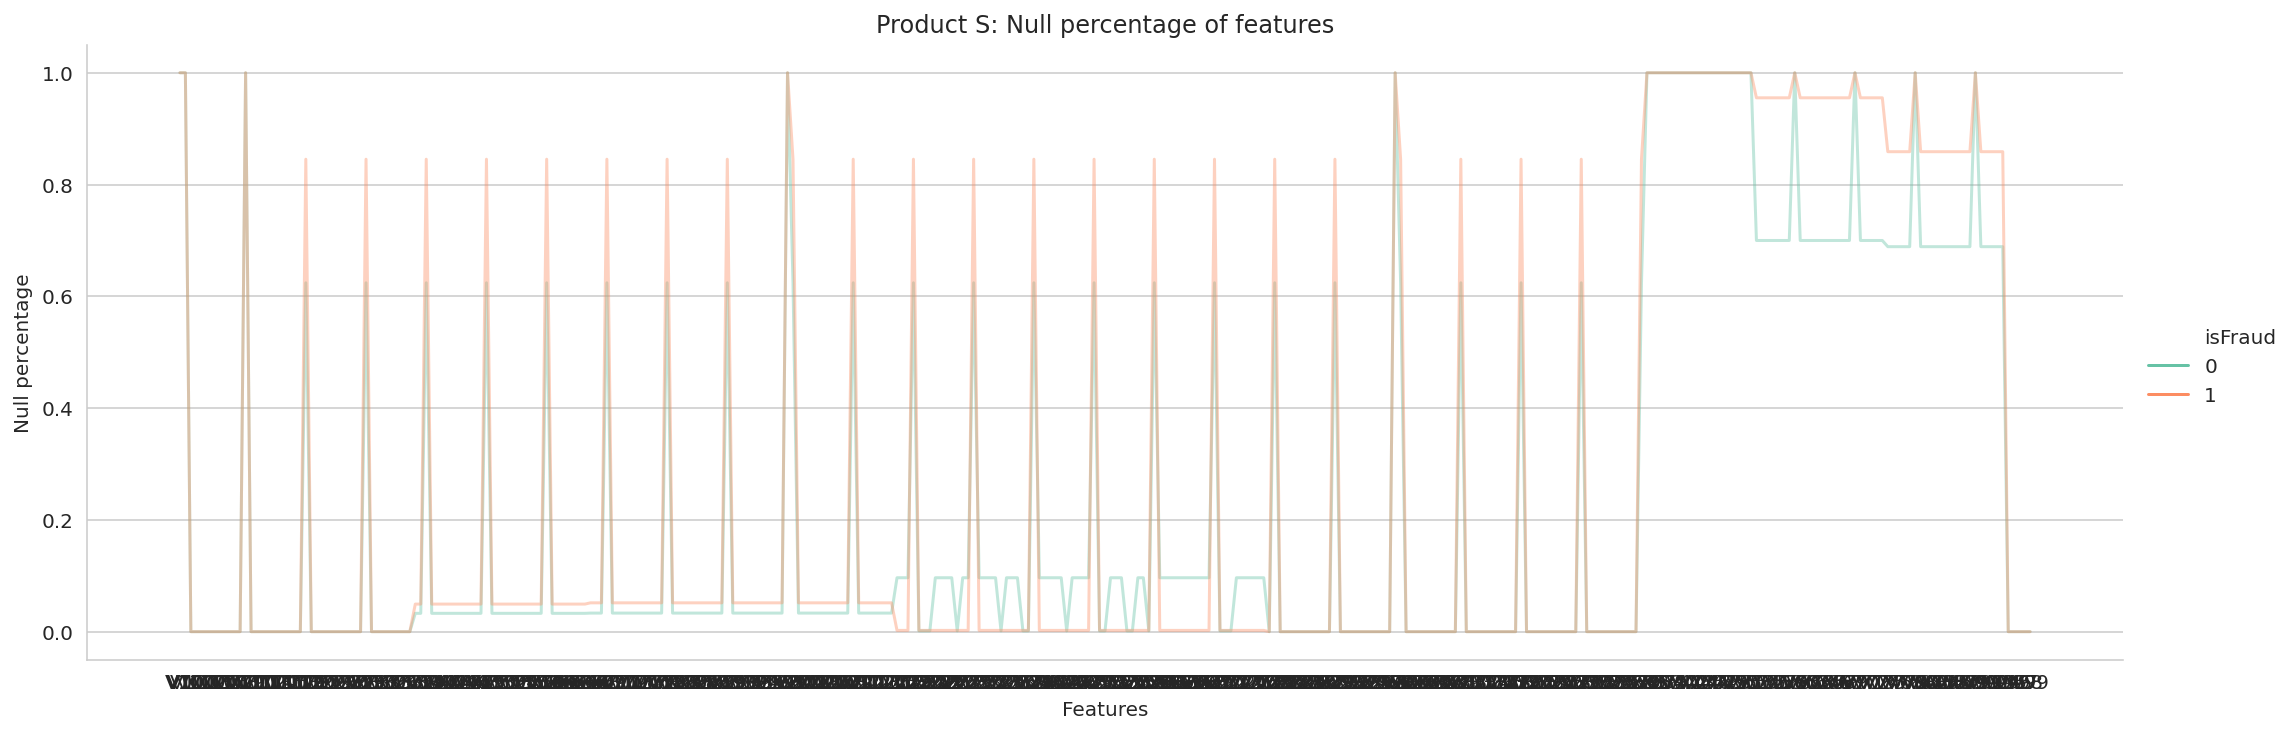

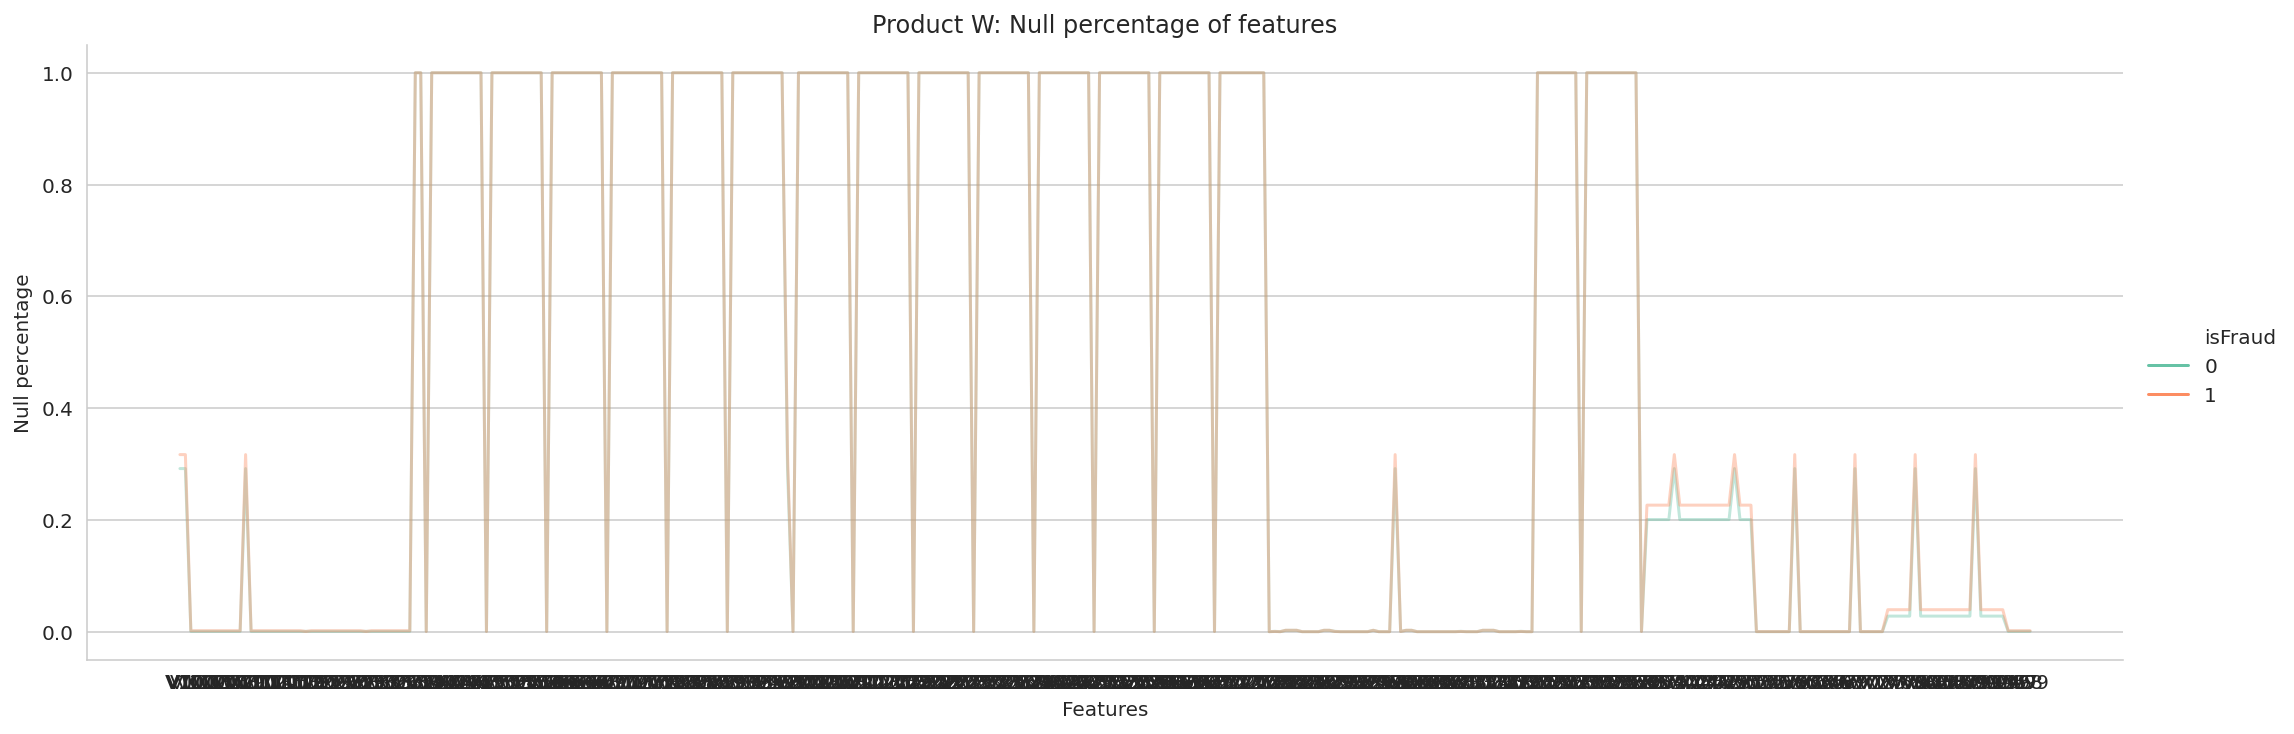

In [33]:
# coltypes = [dist_cols, mix_cols, card_cols, addr_cols, email_cols, c_cols, d_cols, m_cols, v_cols]
typecol = coltypes[8]

t = (
    X_train.join(y_train)
    .set_index(['ProductCD', 'isFraud'])
    [typecol]
    .isnull()
    .reset_index()
    .groupby(by=['ProductCD', 'isFraud'])
    .mean()
    .reset_index()
    .melt(id_vars=['ProductCD', 'isFraud'], value_vars=typecol, var_name='Features', value_name='Null percentage')
    .assign(feature_type = lambda x: x['Features'])
)


for i, product in enumerate(products):
    sns.relplot(data=t[t['ProductCD'] == product], x='Features', y='Null percentage', hue='isFraud', aspect=3, kind='line', alpha=0.4)
    plt.grid(False, axis='x')
    plt.title(f'Product {product}: Null percentage of features')
#     break

We observe that null percentage varies across fraud status, thus there is some information in the null presence which can be learnt. Hence we need to choose a modelling approach which can handle null values by design.

In [34]:
X_train['ProductCD'].value_counts()

W    294442
C     46021
R     25384
H     22141
S      7673
Name: ProductCD, dtype: int64

---------

# Approach

**Preprocessing approaches**
- Sample cases such that all fraud cases are covered and the class imbalance is lessened (20k fraud, 80k legit)
- Remove high null ratio features
- For each product, remove set of features with high null ratio (these features can be different across products)

**Modelling approaches**
- 5 different models for 5 products in the data
- Xgboost, LightGBM algorithms since they natively handle null values

**Final approach**
- Split the data by Products since they show quite independent distributions in null values, suggesting that each product is independent from others to a high degree.
- Use XGBoost to train a binary classifier for each product and Grid Search for hyperparameters
- Combine the product specific trained classifier into a single classifier function for training and predicting
- [Optional] Make a single Linear Regression baseline model which trains on all of the products for comparison
- Performance measurement by F1 score, precision, recall and AUROC

------------

### Steps
- Define final features from coltypes
- Grid Search training function wrapping xgb
- Test run with sample data
- Full run and save trained models
- Predict
- Output graphs

### Set up grid search on xgb

In [92]:
def fit_xgb(train, feature_cols, label_col, data_frac=1, xgb_threads=6, gridcv_threads=4, param_grid=None):
    
    xgb = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=xgb_threads,
        scale_pos_weight=1,
        seed=42,
        verbosity=1
    )
    
    if param_grid is None:
        param_grid = {
    #         'learning_rate': [0.001],
    #         'n_estimators': [500],
            'learning_rate': [0.001, 0.01, 0.1],
            'n_estimators': [500, 1000, 2000, 5000],
            'max_depth': [4, 6],
    #         'min_child_weight': [1, 3, 5],
    #         'gamma': [0, 0.1, 0.2],
    #         'subsample': [0.7, 0.85, 1],
    #         'colsample_bytree': [0.7, 0.85, 1]
        }
    
    c = 1
    for ft in param_grid:
        c *= len(param_grid[ft])
    
    print(f'Parameter combinations: {c}')
    print(f'Total threads:{xgb_threads * gridcv_threads}/32')
    
    gsearch = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='roc_auc',
        n_jobs=gridcv_threads,
        cv=5,
        verbose=2
    )
    
    fit_train = train.sample(frac=data_frac, random_state=42)
    gsearch.fit(fit_train[feature_cols], fit_train[label_col])
    return gsearch

### Train XGBoost models and grid search over number of estimators and learning rate for each product

In [77]:
%%time
gs_dict = dict()
products_except_W = list(set(products) - set(['W']))

for product in tqdm(products_except_W):
    p_train = X_train.join(y_train).loc[lambda x: x['ProductCD'] == product]
    p_gsearch =  fit_xgb(p_train, features, label_col, data_frac=1)
    
    with open(f'Product_{product}_grid_search.pkl', 'wb') as f:
        pickle.dump(p_gsearch, f)
        
    gs_dict[product] = p_gsearch
    
with open(grid_search_result_filename, 'wb') as f:
    pickle.dump(gs_dict, f)

  0%|          | 0/5 [00:00<?, ?it/s]

Parameter combinations: 24
Total threads:24/32
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 53.9min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 171.7min finished
 20%|██        | 1/5 [3:04:57<12:19:48, 11097.14s/it]

Parameter combinations: 24
Total threads:24/32
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 20.5min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 62.7min finished
 40%|████      | 2/5 [4:12:43<7:29:24, 8988.02s/it]  

Parameter combinations: 24
Total threads:24/32
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 23.0min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 69.8min finished
 60%|██████    | 3/5 [5:26:23<4:13:54, 7617.47s/it]

Parameter combinations: 24
Total threads:24/32
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed: 21.5min finished
 80%|████████  | 4/5 [5:48:19<1:35:27, 5727.18s/it]

Parameter combinations: 24
Total threads:24/32
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 237.6min


KeyboardInterrupt: 

In [97]:
# Run reduced parameter space for Product 'W' since W data is huge

w_param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [1000],
}

w_train = X_train.join(y_train).loc[lambda x: x['ProductCD'] == 'W']
w_gsearch =  fit_xgb(w_train, features, label_col, data_frac=1, param_grid=w_param_grid)

with open('Product_W_grid_search.pkl', 'wb') as f:
    pickle.dump(w_gsearch, f)
    
gs_dict['W'] = w_gsearch

with open(grid_search_result_filename, 'wb') as f:
    pickle.dump(gs_dict, f)

### Get prediction

In [171]:
def get_prediction(gsearch_dict, df, features, label_col, products=products):
    
    results = pd.DataFrame()
    
    for p in tqdm(products):
        pdf = df[df['ProductCD'] == p]
        
        mod = gsearch_dict[p]
        actual = pdf[label_col].values
        pred = mod.predict(pdf[features])
        pred_prob = mod.predict_proba(pdf[features])[:, 1]
        
        p_result = pd.DataFrame()
        p_result['product'] = np.ones_like(actual, dtype='object') * p
        p_result['actual'] = actual
        p_result['pred'] = pred
        p_result['pred_prob'] = pred_prob
        results = results.append(p_result)
    return results

In [172]:
%%time
results = get_prediction(gs_dict, X_test.join(y_test), features, label_col)


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

CPU times: user 58.7 s, sys: 1.8 s, total: 1min
Wall time: 13.5 s


In [177]:
results.to_csv(result_filename, index=False)

# Model evaluation

### Accuracy

In [178]:
results = pd.read_csv(result_filename)

In [184]:
accuracy = metrics.accuracy_score(results['actual'], results['pred'])

In [200]:
print(f'Accuracy: {accuracy*100:.4} %')

Accuracy: 98.12 %


Accuracy is quite high but since the class imbalance is severe, accuracy is not the correct metric for measuring model performance.

### Precision/Recall/F1 score

In [202]:
precision = metrics.precision_score(results['actual'], results['pred'])
recall = metrics.recall_score(results['actual'], results['pred'])
f1_score = metrics.f1_score(results['actual'], results['pred'])
auroc = metrics.roc_auc_score(results['actual'], results['pred_prob'])

print(f'Precision: {precision:.3}\nRecall: {recall:.3}\nF1-score: {f1_score:.3}\nAUROC: {auroc:.3}')

Precision: 0.946
Recall: 0.49
F1-score: 0.646
AUROC: 0.934


**Inference:**
- We observe that Precision is high for our models. This implies that out of our predictions, 94.6% percent of cases turn out to be fraudulent transactions
- Recall is not so great. This implies that we are bot able to catch some frauds and our model is labelling 50% frauds as false negatives.
- F1-score is depicting a balanced view of the Precision-Recall trade-off
- AUROC curve is a good value. This implies our model has learnt the class discrimination pretty well

### AUROC curve

Text(0.5, 1.0, 'Area under ROC curve')

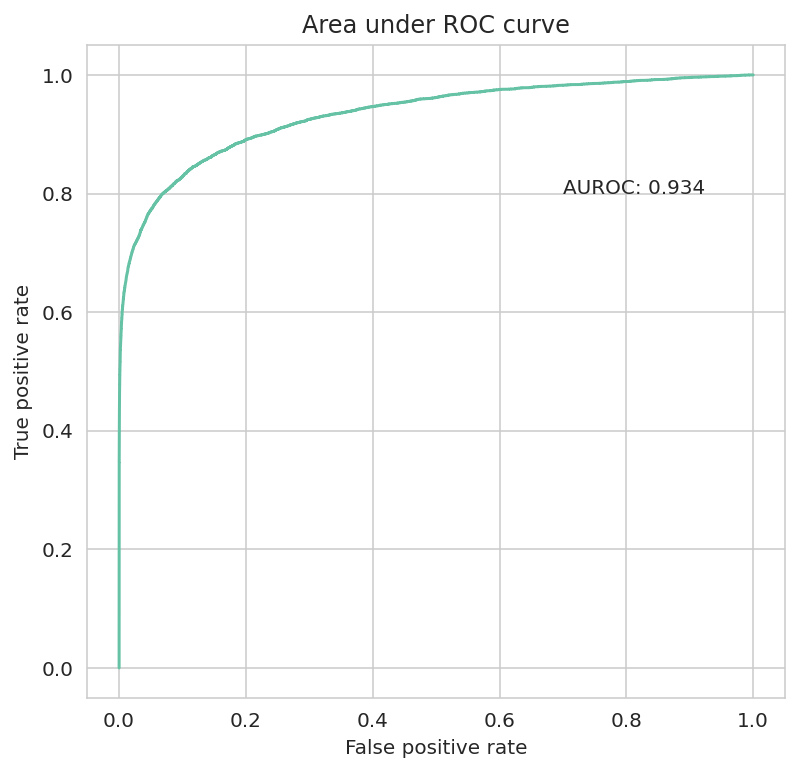

In [240]:
coord = metrics.roc_curve(results['actual'], results['pred_prob'])
roc = pd.DataFrame()
roc['x'] = coord[0]
roc['y'] = coord[1]

fig, ax = plt.subplots(figsize=(6.25, 6))
roc.plot(x='x', y='y', kind='line', ax=ax, legend=False)
ax.annotate(s=f'AUROC: {auroc:.3}', xy=(0.7, 0.8))
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Area under ROC curve')